### 3. Data Preparation
3.1. [Select Data](#3.1-bullet)

3.2. [Clean Data](#3.2-bullet)
  
3.3. [Construct & Format Data](#3.3-bullet)

This notebook will take around 7-8 mins to complete

---------------------------------------------------------

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk

nltk.download('stopwords') # please ignore if you installed nltk.stopwords
nltk.download('wordnet') # please ignore if you installed nltk.wordnet
nltk.download('omw-1.4') # please ignore if you installed nltk.omw-1.4
nltk.download('punkt') # please ignore if you installed nltk.punkt

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3. Data Preparation
### 3.1. Select Data  <a class="anchor" id="3.1-bullet"></a>
The dataset exported from the EDA phase will be loaded to preprocess here before going to the modeling phase. Only features needed for the modeling phase are selected.

In this project, we focus on two data mining goals which are (1) Using NLP to generate the word cloud and find the most frequent words in reviews and (2) Building a machine learning model using the SVM algorithm to predict categorical customer ratings.

Therefore, we will select only reviewText and rating features for this phase.


In [2]:
# Load data
df_review_raw = pd.read_json('Output/reviewEDA.json', lines=True)

In [3]:
# View data sample
df_review_raw.head(3)

,rating,reviewerID,reviewTime,reviewYear,asin,vote,reviewText,reviewLength,category,brand,product
0,4,A240ORQ2LF9LUI,1394496000000,2014,0077613252,0,The materials arrived early and were in excell...,169,Unknown,McGraw-Hill Humanities/Social Sciences/Languages,Connect Personal Health with LearnSmart 1 Seme...
1,4,A1YCCU0YRLS0FE,1393113600000,2014,0077613252,0,I am really enjoying this book with the worksh...,173,Unknown,McGraw-Hill Humanities/Social Sciences/Languages,Connect Personal Health with LearnSmart 1 Seme...
2,1,A1BJHRQDYVAY2J,1392595200000,2014,0077613252,7,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",312,Unknown,McGraw-Hill Humanities/Social Sciences/Languages,Connect Personal Health with LearnSmart 1 Seme...


In [4]:
# Verify data types and non-null values
df_review_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450863 entries, 0 to 450862
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   rating        450863 non-null  int64 
 1   reviewerID    450863 non-null  object
 2   reviewTime    450863 non-null  int64 
 3   reviewYear    450863 non-null  int64 
 4   asin          450863 non-null  object
 5   vote          450863 non-null  int64 
 6   reviewText    450863 non-null  object
 7   reviewLength  450863 non-null  int64 
 8   category      450863 non-null  object
 9   brand         450863 non-null  object
 10  product       450863 non-null  object
dtypes: int64(5), object(6)
memory usage: 37.8+ MB


#### We got 450863 reviews in total. Now, we extract rating and reviewText only

In [5]:
# Get reviewText and rating data
df_review = df_review_raw[['rating','reviewText']].copy()

In [6]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450863 entries, 0 to 450862
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   rating      450863 non-null  int64 
 1   reviewText  450863 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.9+ MB


### 3.2. Clean Data  <a class="anchor" id="3.2-bullet"></a>
Data Cleaning is a must-have step in all machine learning projects. It helps us to avoid Garbage In, Garbage Out (GIGO). In detail, it means that the quality of the output is determined by the quality of the input. Therefore, Cleaning data is so important, and the Data Preparation phase usually takes 70-80% workload of a project (IBM Corporation, 2011). This phase will apply the following methods to clean reviewText:
- Remove html tags and special characters
- Remove punctuation
- Remove stopwords
- Lowercase 
- Lemmatization

**Normalization** includes some cleaning steps:

- Removing html tags, punctuation, and special characters in text data such as '&@#?nbsp;' or '<a href'. 
- Removing stopwords that are too frequent in documents but not informative and meaningful. Lowercase text data to minimize the number of word variants.

**Stemming and Lemmatization** are two of the advanced normalization forms. However, stemming just drops common suffixes based on a dictionary of known word forms, e.g., play, plays, playing, played will be retreated as play. It may lead to missing meaningful words or even erasing the words, e.g., was will be trimmed to wa. Lemmatization considers the role of the word in the sentence and produces better results than stemming when used for text normalization for machine learning (Andrea and Sarah, 2017).

For example, if playing and plays occur in the same document, and playing is recognized as a verb, it will be transformed to play, while plays is recognized as a noun, it will be kept. However, the advantage of lemmatization is the performance. I tried to lemmatization for nouns, verbs, adverbs, and adjectives, but it took more than 30 mins to complete. After considering the meaning of text data, I decided to use lemmatization for verbs because verbs have most variants.


In [7]:
# Check html tags in reviewText
df_review[df_review['reviewText'].str.contains("<a")]

,rating,reviewText
33,5,I have had Dreamweaver MX2004 since it came ou...
47,5,Some people learn more by watching than by rea...
57,5,"Had a chance to try this out, here are a few i..."
68,4,"The ""Learn by Video"" program for Flash CS5 wou..."
166,5,This is one of the best tools for complete beg...
...,...,...
449360,5,"<a data-hook=""product-link-linked"" class=""a-li..."
449698,2,"<a data-hook=""product-link-linked"" class=""a-li..."
450118,2,"<a data-hook=""product-link-linked"" class=""a-li..."
450667,4,"<a data-hook=""product-link-linked"" class=""a-li..."


In [8]:
# sample
df_review.reviewText[57]

'Had a chance to try this out, here are a few impressions:\n\nEasy to use, well-designed, and useful.\n\nBUT... at a fairly basic "this is Lightroom" level.  So, if you\'re new to Lightroom, and a visual learner (as opposed to wanting to read everything in a book), this is an awesome resource.  It\'s kind of like having an experienced photographer friend sit down with you and a copy of LR3 for 10 hours and go over every feature, in a reasonable degree of depth, one feature at a time.  But you get to pause, rewind, and rewatch it whenever you want, add bookmarks to favorite parts you want to review later, etc.\n\nYou can also learn LR3 on your own; that\'s what I did.  I\'d been using the program for over a year before getting this, so I didn\'t think I had much to learn.  While I wasn\'t sure how useful this would be, I was pleasantly surprised.  I use primarily the Library and Develop modules (all the time), and was hoping to learn more about the other three (Print, Web, and Slideshow

In [9]:
# take a look at document has length < 200
df_review[(df_review['reviewText'].str.contains("<a")) & (df_review['reviewText'].str.len() < 200)]

,rating,reviewText
55161,1,BEWARE!!!!!!\nPIRATED <and used> copy of Corel...
63697,4,"<a data-hook=""product-link-linked"" class=""a-li..."
141588,5,"<a data-hook=""product-link-linked"" class=""a-li..."
296716,5,A great way to read a novel on a smartphone.<a...
304069,5,"<a data-hook=""product-link-linked"" class=""a-li..."
355879,1,"don't get it.<a data-hook=""product-link-linked..."
398900,5,"<a data-hook=""product-link-linked"" class=""a-li..."
418609,1,This is not what I was looking for but I did f...
435159,5,"<a data-hook=""product-link-linked"" class=""a-li..."
449698,2,"<a data-hook=""product-link-linked"" class=""a-li..."


In [10]:
# sample of a document containing html tags and special characters 
df_review.reviewText[355879]

'don\'t get it.<a data-hook="product-link-linked" class="a-link-normal" href="/onlineTV-Free-Download/dp/B01H39M7ME/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">onlineTV Free [Download</a>]doesnt work for me.'

In [11]:
# check documents containing non Ascii character
df_review.reviewText.map(lambda x: len(x.encode('ascii', errors='ignore')) != len(x)).value_counts()

False    450863
Name: reviewText, dtype: int64

In [12]:
# check stopwords list
stop_list = stopwords.words('english')
print(stop_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
# view punctuation
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


#### Data Cleaning functions

In [14]:
def remove_html_tag(text):
    html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|a href|http.*?')
    return re.sub(html,'',text)

def remove_punctuation(text):
    return text.translate(str.maketrans('','',string.punctuation))

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    cleanText = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return cleanText

def normalize(text):
    cleantext = remove_html_tag(text)
    cleantext = remove_punctuation(cleantext)
    cleantext = cleantext.lower()
    cleantext = remove_stopwords(cleantext)
    return cleantext

def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    newText = " ".join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])
    return newText

#### Apply Data Cleaning functions to dataset
The following two steps will take around 2 minutes each to complete

#### Normalization

In [15]:
# This line of code takes around 1-2 mins to complete
df_review['normalizedText'] = df_review['reviewText'].map(lambda text: normalize(text))

#### Lemmatization

In [16]:
# This line of code takes around 1-2 mins to complete
df_review['cleanText'] = df_review['normalizedText'].map(lambda text: word_lemmatizer(text))

#### View and verify data

In [17]:
df_review.head(5)

,rating,reviewText,normalizedText,cleanText
0,4,The materials arrived early and were in excell...,materials arrived early excellent condition ho...,materials arrive early excellent condition how...
1,4,I am really enjoying this book with the worksh...,really enjoying book worksheets make review go...,really enjoy book worksheets make review goals...
2,1,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",taking class dont waste money called book 1400...,take class dont waste money call book 14000 bo...
3,3,This book was missing pages!!! Important pages...,book missing pages important pages couldnt ans...,book miss page important page couldnt answer t...
4,5,I have used LearnSmart and can officially say ...,used learnsmart officially say amazing study t...,use learnsmart officially say amaze study tool...


In [18]:
# verify punctuation
punctuation = set(string.punctuation)
df_review.cleanText.map(lambda v: bool(set(v) & punctuation)).value_counts()

False    450863
Name: cleanText, dtype: int64

In [19]:
# verify html tags
df_review[df_review['cleanText'].str.contains("<a")]

,rating,reviewText,normalizedText,cleanText


#### There is no punctuation, special characters, and html tags in cleanText anymore. Next, we will drop unnecessary columns to create a new data frame.

In [20]:
review3 = df_review.drop(columns=['reviewText','normalizedText'], axis=1).copy()

In [21]:
# set option to display full string 
# pd.options.display.max_colwidth = 500
pd.set_option('display.max_colwidth', None)
review3.head(3)

,rating,cleanText
0,4,materials arrive early excellent condition however money spend really shouldve come binder loose leafmaterial great
1,4,really enjoy book worksheets make review goals make remind human sexuality classworkhealth
2,1,take class dont waste money call book 14000 book isint even bind loose leaf provide binder turn buy access book mcgraw hill connect core 7000 book complete waste moneyare kid


In [22]:
# verify review data frame summary
review3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450863 entries, 0 to 450862
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   rating     450863 non-null  int64 
 1   cleanText  450863 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.9+ MB


### 3.3. Construct & Format Data <a class="anchor" id="3.3-bullet"></a>
Our second Data mining goal is to predict categorical customer ratings based on customer reviews.

Therefore, We will add ratingClass column into the dataset by dividing rating into two categories: Good (rating >=4) and Bad (rating < 4)

ratingClass will be our target variable for predicting rating classification based on reviews.


In [23]:
review3['ratingClass'] = review3['rating'].apply(lambda x: "Good" if x >3 else "Bad")

In [24]:
review3.head()

,rating,cleanText,ratingClass
0,4,materials arrive early excellent condition however money spend really shouldve come binder loose leafmaterial great,Good
1,4,really enjoy book worksheets make review goals make remind human sexuality classworkhealth,Good
2,1,take class dont waste money call book 14000 book isint even bind loose leaf provide binder turn buy access book mcgraw hill connect core 7000 book complete waste moneyare kid,Bad
3,3,book miss page important page couldnt answer test question never happen beforemissing page,Bad
4,5,use learnsmart officially say amaze study tool quickly simply adapt style learn access anytime go start use learnsmart quickly realize best way learn study business student use learnsmart account class however use account ii class grade difference account account ii whole letter grade thank learnsmart every college student definitely check outbest study product,Good


### 3.4 Generate Word Cloud
Our first Data Mining goal is to use NLP to generate the word cloud and find the most frequent words in reviews.

Word Cloud will be generated for all text data, for good rating class, and for bad rating class.


#### WordCloud for all text data

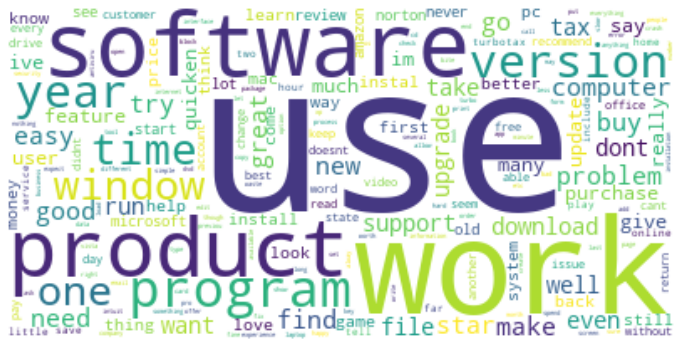

In [25]:
# this line of code takes around 15-20s to complete
text1 = " ".join(word for word in review3.cleanText)
word_cloud1 = WordCloud(collocations = False, background_color = 'white').generate(text1)
plt.figure(figsize=(12,8))
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that ('work','use','software','product','program','version', 'year') are the words mentioned most in reviews. 

Their frequencies in the corpus are much higher than the remaining words. Therefore, we will try to remove them from the list of words for Good rating and Bad rating to get more insight. This removal is only for Word Cloud.


#### WordCloud for Good rating class

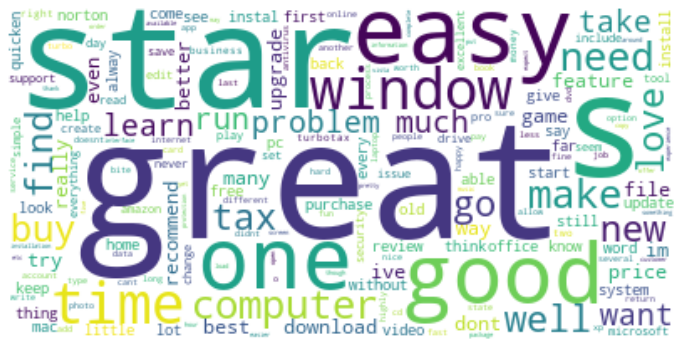

In [26]:
# this line of code takes around 15-20s to complete
text2 = " ".join(word for word in review3[review3['ratingClass'] == "Good"].cleanText)
stopword = ['work','use','software','product','program','version','year']
for word in stopword:
    text2=text2.replace(word,"")
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)
plt.figure(figsize=(12,8))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

#### WordCloud for Bad rating class

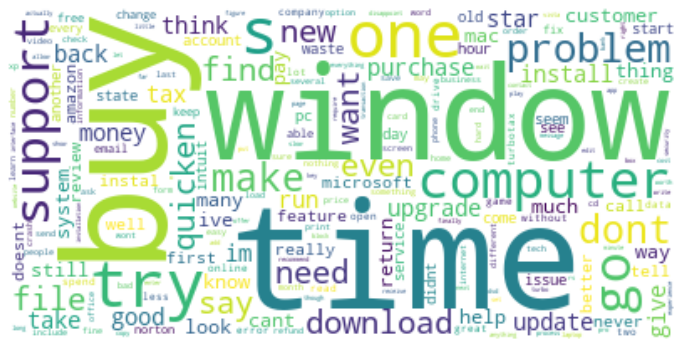

In [27]:
# this line of code takes around 15-20s to complete
text3 = " ".join(word for word in review3[review3['ratingClass'] == "Bad"].cleanText)
stopword = ['work','use','software','product','program','version','year']
for word in stopword:
    text3=text3.replace(word,"")
word_cloud3 = WordCloud(collocations = False, background_color = 'white').generate(text3)
plt.figure(figsize=(12,8))
plt.imshow(word_cloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

#### !!! Hoorey !!! Dataset is ready for Data Modeling now !!!!

#### Export to json file stored in /Output folder for next step

In [28]:
review3.to_json('Output/reviewPreprocessing.json', orient='records', lines=True)

#### Now, we completed the phase 03. Data Preparation. 
Go to the next step [04.Data Modeling&Evaluation Notebook](CA_TanThienNguyen_C00278719_04_Modeling&Evaluation.ipynb)